In [1]:
from __future__ import annotations

import math
import random
from typing import List, Set, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph

In [2]:
h = 0.00001

# inputs
a = 2.0
b = 3.0
c = 6.0

d = a+b
e = d*c

print(e)

30.0


In [3]:
class Value:

    def __init__(self, data: float, label: str='', children: tuple=(), op: str='') -> None:
        self.label = label
        self.data = data
        self._prev = set(children)
        self._op = op

        self._backward = lambda: None
        self.grad = 0.0

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other: Union[Value, float, int]) -> Value:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other), op="+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other: Union[Value, float, int]) -> Value:
        return self + other

    def __sub__(self, other: Union[Value, float, int]) -> Value:
        return self + (other * -1.0)

    def __rsub__(self, other: Union[Value, float, int]) -> Value:
        return self - other

    def __mul__(self, other: Union[Value, float, int]) -> Value:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other), op="*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other:Value) -> Value:
        return self * other

    def tanh(self) -> Value:
        d = self.data
        t = (math.exp(2*d) - 1) / (math.exp(2*d) + 1)

        out = Value(t, children=(self, ), op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self) -> Value:
        d = self.data
        t = math.exp(d)

        def _backward():
            self.grad += t * out.grad
        
        out = Value(t, children=(self, ), op="exp")
        out._backward = _backward

        return out

    def __pow__(self, other: Union[int, float]) -> Value:
        d = self.data
        t = d**other

        def _backward():
            self.grad += other * d**(other - 1) * out.grad

        out = Value(t, children=(self, ), op=f'**{other}')
        out._backward = _backward

        return out

    def __truediv__(self, other:Value) -> Value:
        return self * other**(-1)

    def backward(self):
        def build_topo(n:Value):
            topo = []
            visited = set()
            def build(n:Value):
                if n not in visited:
                    visited.add(n)
                    for child in n._prev:
                        build(child)
                    topo.append(n)
            build(n)
            return topo

        topo = build_topo(self)
        rev = reversed(topo)
        self.grad = 1.0
        for i in rev:
            i._backward()

    def draw_dot(self) -> Digraph:
        def trace(root: Value) -> Tuple[Set[Value], Set[Tuple[Value, Value]]]:
            nodes, edges = set(), set()
            
            def build(v: Value):
                if v not in nodes:
                    nodes.add(v)
                    for c in v._prev:
                        edges.add((c, v))
                        build(c)
            
            build(root)
            return nodes, edges

        dot = Digraph(graph_attr={'rankdir': 'LR'})

        nodes, edges = trace(self)

        for n in nodes:
            node_name = str(id(n))
            dot.node(name=node_name, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
            if n._op != '':
                op_name = node_name + n._op
                dot.node(name=op_name, label=n._op)
                dot.edge(op_name, node_name)
        
        for e1, e2 in edges:
            from_node_name = str(id(e1))
            to_node_name = str(id(e2)) + e2._op
            dot.edge(from_node_name, to_node_name)
        
        return dot

In [4]:
a = Value(2.0, 'a')
b = Value(3.0, 'b')

c = a * b
c.label = 'c'

d = Value(4.0, 'd')

e = d + c
e.label = 'e'

f = Value(5.0, 'f')

g = e * f
g.label = 'L'


In [5]:
g.grad = 1
g._backward()

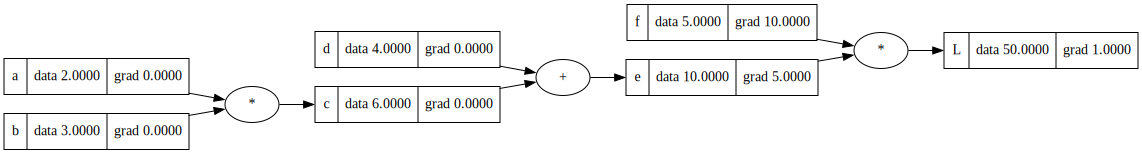

In [6]:
g.draw_dot()

In [7]:
w1 = Value(-3.0, 'w1')
x1 = Value(2.0, 'x1')

w1x1 = w1*x1; w1x1.label = 'w1*x1'

w2 = Value(1.0, 'w2')
x2 = Value(0.0, 'x2')

w2x2 = w2*x2; w2x2.label = 'w2*x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label='w1*x1 + w2*x2'

b = Value(6.8813735870195432, 'b')
# b = Value('b', 6.7)

n = w1x1w2x2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'


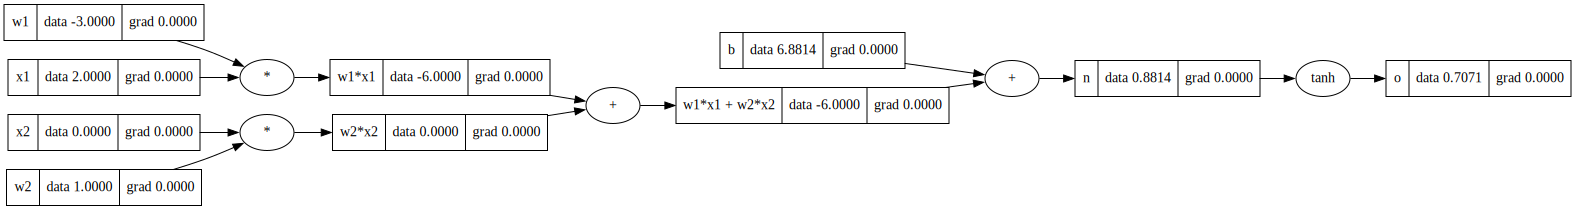

In [8]:
o.draw_dot()

In [9]:
o.backward()

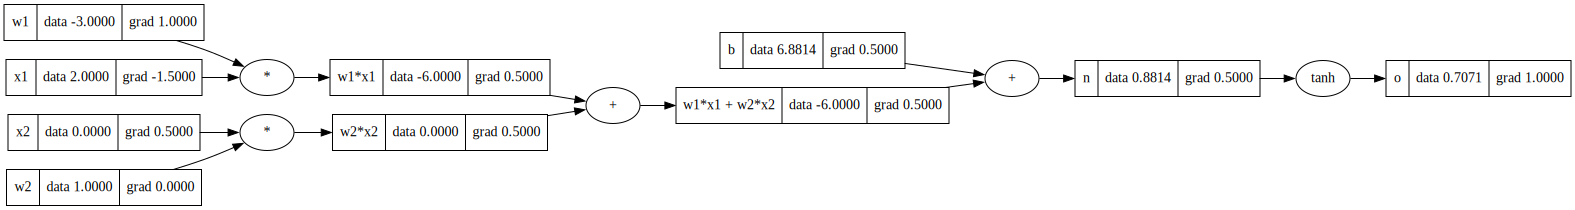

In [10]:
o.draw_dot()

In [11]:
w1 = Value(-3.0, 'w1')
x1 = Value(2.0, 'x1')

w1x1 = w1*x1; w1x1.label = 'w1*x1'

w2 = Value(1.0, 'w2')
x2 = Value(0.0, 'x2')

w2x2 = w2*x2; w2x2.label = 'w2*x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label='w1*x1 + w2*x2'

b = Value(6.8813735870195432, 'b')
# b = Value('b', 6.7)

n = w1x1w2x2 + b; n.label = 'n'

o = ((n * 2.0).exp() - 1.0) / ((n * 2.0).exp() + 1.0)


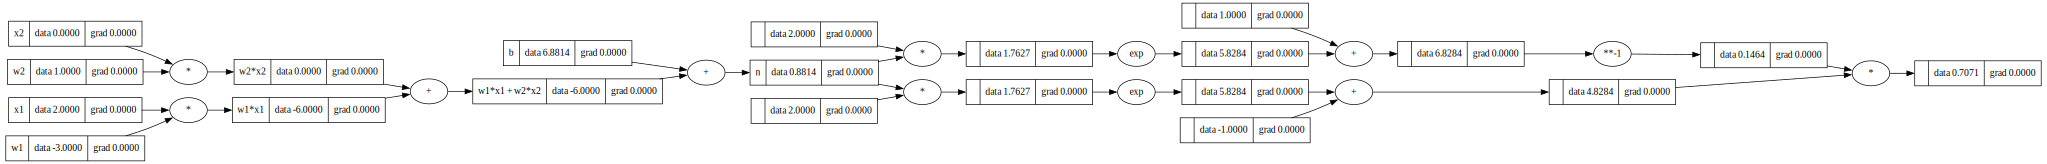

In [12]:
o.draw_dot()

In [13]:
o.backward()

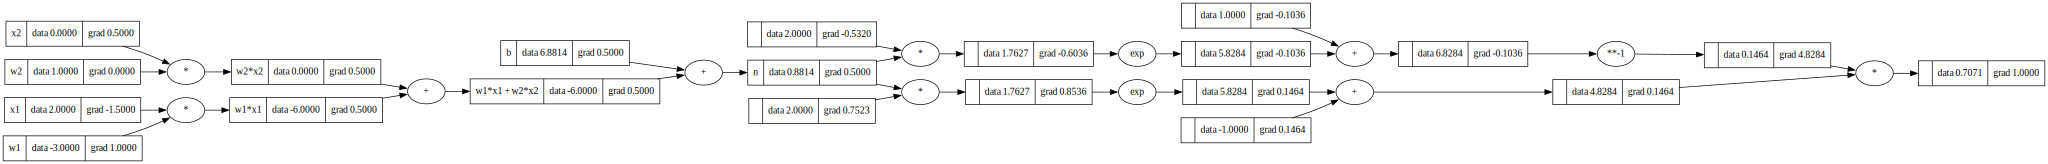

In [14]:
o.draw_dot()

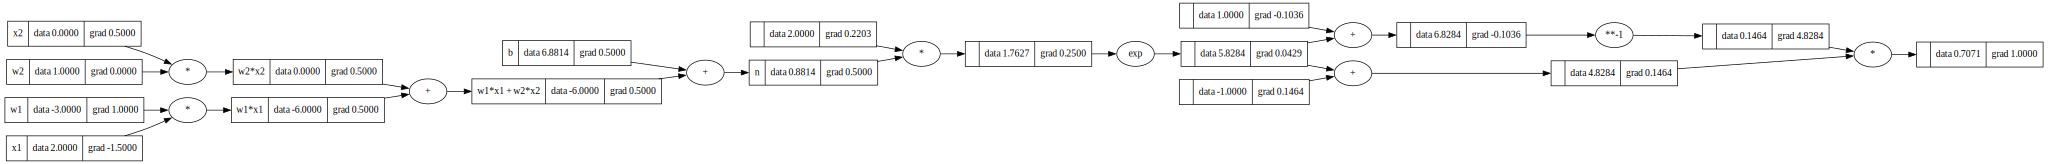

In [15]:
w1 = Value(-3.0, 'w1')
x1 = Value(2.0, 'x1')

w1x1 = w1*x1; w1x1.label = 'w1*x1'

w2 = Value(1.0, 'w2')
x2 = Value(0.0, 'x2')

w2x2 = w2*x2; w2x2.label = 'w2*x2'

w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label='w1*x1 + w2*x2'

b = Value(6.8813735870195432, 'b')
# b = Value('b', 6.7)

n = w1x1w2x2 + b; n.label = 'n'

e = (n * 2.0).exp()

o = (e - 1.0) / (e + 1.0)

o.backward()
o.draw_dot()

In [16]:
import torch

/Users/lucasvanwalstijn/miniconda3/envs/fastai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True 
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True 

w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True 
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True 

b = torch.Tensor([6.8813735870195432]); b.requires_grad = True 

n = w1*x1 + w2*x2 + b;
o = torch.tanh(n)

o.backward()

print(o.data.item())

print('-----')

print('w1', w1.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())
print('x2', x2.grad.item())

0.7071066904050358
-----
w1 1.0000002567688737
x1 -1.5000003851533106
w2 0.0
x2 0.5000001283844369


In [18]:
class Neuron:

    def __init__(self, n_input: int) -> None:
        self.n_input = n_input
        self.weights = [Value(random.random()) for n in range(n_input)]
        self.bias = Value(random.random())
        self.parameters = self.weights + [self.bias]

    def __repr__(self) -> str:
        return f'Neuron(n_input={self.n_input})'

    def __call__(self, data) -> Value:
        assert len(data) == self.n_input, "data doesn't match neuron shape"
        n = sum([w * x for w,x in zip(data, self.weights)], self.bias)
        return n.tanh()



In [19]:
n = Neuron(3)

In [20]:
n.weights

[Value(data=0.13844508567445735),
 Value(data=0.7269024921992243),
 Value(data=0.030218665193346705)]

In [21]:
data = [Value(1.0), Value(1.0), Value(2.0)]
n(data)

Value(data=0.8874842974322794)

In [22]:
class Layer():

    def __init__(self, n_input: int, n_output: int) -> None:
        self.n_input = n_input
        self.n_output = n_output
        self.neurons = [Neuron(n_input) for i in range(self.n_output)]
        self.parameters = [p for n in self.neurons for p in n.parameters]

    def __repr__(self) -> str:
        return f"Layer(n_input: {self.n_input}, n_output: {self.n_output})"

    def __call__(self, x) -> List[Value]:
        outs = [n(x) for n in self.neurons]
        return outs
        

In [23]:
l = Layer(3,5)
l

Layer(n_input: 3, n_output: 5)

In [24]:
l([Value(2.0), Value(1.0), Value(-2.0)])

[Value(data=0.750690369798727),
 Value(data=0.7946555831552661),
 Value(data=0.9252312395889709),
 Value(data=0.6957979744095983),
 Value(data=0.9633817606000092)]

In [25]:
from typing import Any


class MLP():

    def __init__(self, n_in:int, n_outs:List[int]) -> None:
        self.n_in = n_in
        l = [n_in] + n_outs
        self.layers = [Layer(l[i], l[i+1]) for i in range(len(n_outs))]
        self.parameters = [p for l in self.layers for p in l.parameters]

    def __call__(self, data:List[Value]) -> Any:
        assert len(data) == self.n_in, "Given data doesn't match network architecture"
        for layer in self.layers:
            data = layer(data)
        return data[0] if len(data) == 1 else data

    def clear_grad(self):
        for p in self.parameters:
            p.grad = 0

    def gradient_check(self, data, h=0.0000001):
        original_res = self(data)
        self.clear_grad()
        if isinstance(original_res, Value):
            original_res.backward()
            for p in self.parameters:
                p.data += h
                res = self(data)
                if isinstance(res, Value):
                    L = (res.data - original_res.data) / h
                    assert math.isclose(L, p.grad, abs_tol=10**-4), f"{p.grad}, {L}"
                    p.data -= h
        else:
            raise NotImplementedError('Gradient check only implemented for MLPs in which last layer consists of 1 neuron')


    def draw_dot(self):
        dot = Digraph(graph_attr={'rankdir': 'LR'})
        for i_layer in range(0, len(self.layers)):
            layer = self.layers[i_layer]
            for i_input in range(0, layer.n_input):
                for i_output in range(0, layer.n_output):
                    dot.edge(f'layer {i_layer} node {i_input}', f'layer {i_layer + 1} node {i_output}')
        return dot



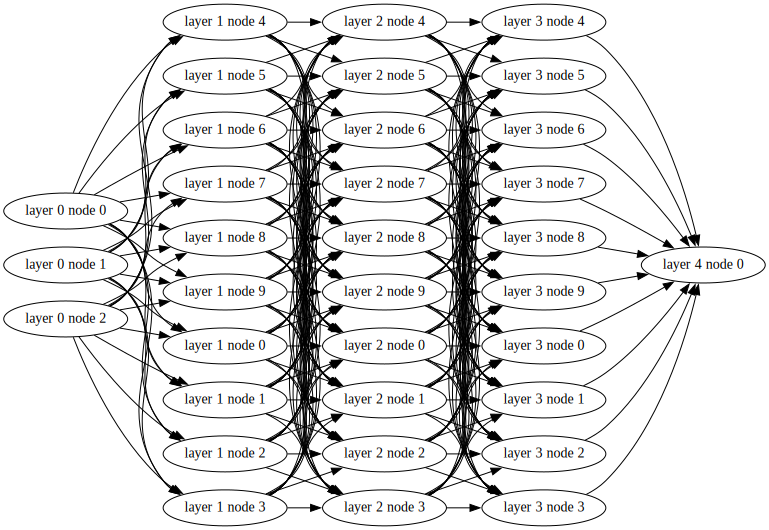

In [26]:
network = MLP(3, [10, 10, 10, 1])
network.draw_dot()

In [27]:
out = network([Value(3.0, 'x1'), Value(2.0, 'x2'), Value(-5.0, 'x3')])

In [28]:
out

Value(data=0.9998010646004957)

In [29]:
network.gradient_check([Value(3.0, 'x1'), Value(2.0, 'x2'), Value(-5.0, 'x3')])

In [30]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [31]:
def mse(true, pred):
    return (true - pred)**2

In [32]:
learning_rate = 0.1

In [33]:
n = MLP(3, [4,4,1])
for i in range(50):
    outs = [n([Value(i) for i in j]) for j in xs]
    cost = sum([mse(i[0], i[1]) for i in zip(ys, outs)], Value(0))
    print(cost)
    cost.backward()
    for p in n.parameters:
        p.data -= learning_rate * p.grad
        p.grad = 0

Value(data=7.924698778489189)
Value(data=7.913068125308063)
Value(data=7.897451300970821)
Value(data=7.875503066206826)
Value(data=7.8427076369545)
Value(data=7.789304333424287)
Value(data=7.690490946228416)
Value(data=7.466320296032956)
Value(data=6.752044972123657)
Value(data=4.1981926445154345)
Value(data=4.827625222046642)
Value(data=5.989952388546861)
Value(data=4.855382493212042)
Value(data=6.006253644512829)
Value(data=4.819861590124695)
Value(data=6.0055252699064825)
Value(data=4.817469897711209)
Value(data=6.009254517919271)
Value(data=4.806463949645618)
Value(data=6.009035012682968)
Value(data=4.803072274280416)
Value(data=6.00944992846272)
Value(data=4.798273512447938)
Value(data=6.008416923060345)
Value(data=4.796050435782876)
Value(data=6.007197544704665)
Value(data=4.79385784643001)
Value(data=6.00518931510493)
Value(data=4.792783224734693)
Value(data=6.002747847661509)
Value(data=4.792026301099982)
Value(data=5.999662394965065)
Value(data=4.791866350351058)
Value(data=5.